# Projeto 3: Modelo de Score de Crédito com Análise de Justiça (Fairness)

**Parceiro de IA:** Victor Alexandre
**Data:** 07 de Julho de 2025

### 1. Configuração do Ambiente

Nesta etapa, instalamos as bibliotecas necessárias. O destaque deste projeto é a `fairlearn`, que nos permitirá avaliar se nosso modelo de crédito é justo com diferentes grupos demográficos, e a `lightgbm` para a construção de um modelo de classificação de alta performance.

In [1]:
# Célula 1 (VERSÃO FINAL E LIMPA): Instalação Essencial

!pip install kaggle -q
!pip install lightgbm -q
!pip install fairlearn -q

print("Bibliotecas essenciais instaladas com sucesso!")

Bibliotecas essenciais instaladas com sucesso!


### 2. Importação das Bibliotecas

Importamos os pacotes que utilizaremos. Cada um tem um papel crucial:
- **Pandas e NumPy:** Manipulação de dados.
- **Matplotlib, Seaborn, Scikit-plot:** Para visualizações ricas e análise exploratória.
- **Scikit-learn:** Para pré-processamento e avaliação do modelo.
- **LightGBM:** Nosso algoritmo de Gradient Boosting para construir o modelo de score de crédito.
- **Fairlearn:** O coração da nossa análise de justiça, para medir e visualizar o viés do modelo.

In [12]:
# Célula 2 (VERSÃO CORRIGIDA E COMPLETA): Importações

# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay

# >> CORREÇÃO AQUI <<
# Importando explicitamente todas as funções de métrica que vamos usar
from sklearn.metrics import (roc_auc_score,
                             classification_report,
                             confusion_matrix,
                             accuracy_score,
                             precision_score,
                             recall_score)


# Análise de Justiça (Fairness)
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference

# Configurações
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


### 3. Carregamento dos Dados

## 3. Carregamento dos Dados

Para este projeto, utilizaremos o dataset "Home Credit Default Risk" do Kaggle.


In [13]:
# Célula 3 (VERSÃO FINAL E ROBUSTA): Download e Descompactação Total

from google.colab import files
import os

# Apenas para garantir que o kaggle.json está no lugar certo
# Não precisa fazer o upload novamente se já fez
if not os.path.exists('kaggle.json'):
    print("Por favor, faça o upload do seu arquivo kaggle.json")
    files.upload()

# Configura o diretório do Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Nome da competição e do arquivo zip
COMPETITION_NAME = 'home-credit-default-risk'
ZIP_FILE = f'{COMPETITION_NAME}.zip'

# Baixa o dataset
print(f"Baixando dados da competição: {COMPETITION_NAME}...")
# Adicionando --force para garantir que ele baixe novamente se necessário
!kaggle competitions download -c {COMPETITION_NAME} --force

# >> PONTO CHAVE AQUI <<
# Descompactando o arquivo ZIP correto
print(f"\nDescompactando o arquivo principal: {ZIP_FILE}...")
# Extrai para uma pasta chamada 'data' para manter tudo organizado
!unzip -o {ZIP_FILE} -d data/

# Listando TODOS os arquivos que foram extraídos para a pasta 'data'
print("\nArquivos extraídos na pasta 'data/':")
!ls data/

print("\nProcesso de download e descompactação concluído.")

Baixando dados da competição: home-credit-default-risk...
 97% 666M/688M [00:07<00:00, 224MB/s]
100% 688M/688M [00:07<00:00, 98.8MB/s]

Descompactando o arquivo principal: home-credit-default-risk.zip...
Archive:  home-credit-default-risk.zip
  inflating: data/HomeCredit_columns_description.csv  
  inflating: data/POS_CASH_balance.csv  
  inflating: data/application_test.csv  
  inflating: data/application_train.csv  
  inflating: data/bureau.csv         
  inflating: data/bureau_balance.csv  
  inflating: data/credit_card_balance.csv  
  inflating: data/installments_payments.csv  
  inflating: data/previous_application.csv  
  inflating: data/sample_submission.csv  

Arquivos extraídos na pasta 'data/':
application_test.csv	 HomeCredit_columns_description.csv
application_train.csv	 installments_payments.csv
bureau_balance.csv	 POS_CASH_balance.csv
bureau.csv		 previous_application.csv
credit_card_balance.csv  sample_submission.csv

Processo de download e descompactação concluído.


### 4. Análise Exploratória e Pré-processamento Inicial

Este dataset é muito rico, com mais de 100 colunas. Para manter o foco do projeto na modelagem e na análise de fairness, vamos selecionar um subconjunto de features relevantes.

**Nosso objetivo aqui é:**
1.  Carregar os dados.
2.  Selecionar as colunas de interesse.
3.  Analisar a variável alvo (`TARGET`) e a feature sensível (`CODE_GENDER`).
4.  Realizar um pré-processamento básico, como o `LabelEncoding` para variáveis categóricas.

In [14]:
# Célula 4 (VERSÃO CORRETA E AJUSTADA): Carregando da pasta 'data'

# >> A MUDANÇA ESTÁ AQUI <<
# O caminho para o arquivo agora inclui a pasta 'data/'
file_path = 'data/application_train.csv'

try:
    df = pd.read_csv(file_path)

    print("Formato original do DataFrame:", df.shape)

    # O restante do código permanece exatamente o mesmo
    selected_features = [
        'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
        'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE'
    ]

    df_selected = df[selected_features].copy()
    df_selected = df_selected[df_selected['CODE_GENDER'] != 'XNA']
    print("Formato do DataFrame após seleção de features:", df_selected.shape)

    for col in df_selected.select_dtypes(include='object').columns:
        df_selected[col].fillna(df_selected[col].mode()[0], inplace=True)

    for col in df_selected.select_dtypes(include=np.number).columns:
        df_selected[col].fillna(df_selected[col].median(), inplace=True)

    categorical_cols = df_selected.select_dtypes(include='object').columns
    for col in categorical_cols:
        le = LabelEncoder()
        df_selected[col] = le.fit_transform(df_selected[col])

    print("\nPré-processamento inicial concluído.")
    display(df_selected.head())

except FileNotFoundError:
    print(f"\nERRO: O arquivo em '{file_path}' não foi encontrado.")

Formato original do DataFrame: (307511, 122)
Formato do DataFrame após seleção de features: (307507, 14)


/tmp/ipython-input-14-2557720062.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_selected[col].fillna(df_selected[col].mode()[0], inplace=True)
/tmp/ipython-input-14-2557720062.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu


Pré-processamento inicial concluído.


,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE
0,1,1,0,1,0,202500.0,406597.5,24700.5,7,4,3,-9461,-637,8
1,0,0,0,0,0,270000.0,1293502.5,35698.5,4,1,1,-16765,-1188,3
2,0,1,1,1,0,67500.0,135000.0,6750.0,7,4,3,-19046,-225,8
3,0,0,0,1,0,135000.0,312682.5,29686.5,7,4,0,-19005,-3039,8
4,0,1,0,1,0,121500.0,513000.0,21865.5,7,4,3,-19932,-3038,3


### Análise da Distribuição

Vamos analisar duas distribuições cruciais:
1.  **Taxa de Inadimplência (`TARGET`):** Isso nos mostra o quão desbalanceado é o nosso problema.
2.  **Taxa de Inadimplência por Gênero:** Uma primeira olhada para ver se existem diferenças aparentes na taxa de inadimplência entre os grupos que vamos analisar. Isso é um indício, mas não uma prova de viés.

/tmp/ipython-input-15-4130340737.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['Pagou (0)', 'Não Pagou (1)'])
/tmp/ipython-input-15-4130340737.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['Feminino', 'Masculino'])


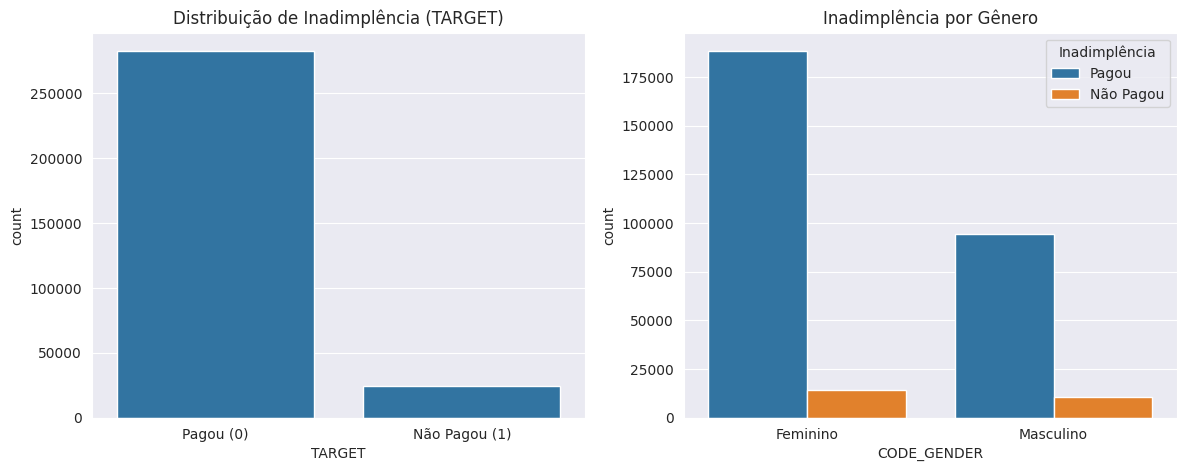

Taxa de Inadimplência por Gênero:


TARGET,0,1
CODE_GENDER,,
0,0.930007,0.069993
1,0.898581,0.101419


In [15]:
# Célula 5: Análise da variável alvo e da feature sensível

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Distribuição da variável alvo
sns.countplot(x='TARGET', data=df_selected, ax=ax[0])
ax[0].set_title('Distribuição de Inadimplência (TARGET)')
ax[0].set_xticklabels(['Pagou (0)', 'Não Pagou (1)'])


# Distribuição da inadimplência por gênero
sns.countplot(x='CODE_GENDER', hue='TARGET', data=df_selected, ax=ax[1])
ax[1].set_title('Inadimplência por Gênero')
ax[1].set_xticklabels(['Feminino', 'Masculino'])
plt.legend(title='Inadimplência', labels=['Pagou', 'Não Pagou'])

plt.show()

# Calculando a taxa de inadimplência por gênero
gender_default_rate = df_selected.groupby('CODE_GENDER')['TARGET'].value_counts(normalize=True).unstack()
print("Taxa de Inadimplência por Gênero:")
display(gender_default_rate)

# Parte 2: Modelagem e Avaliação de Performance


### 5. Modelagem do Score de Crédito

Com os dados preparados, vamos construir nosso modelo preditivo.

**1. Separação dos Dados:** Dividimos o dataset em `X` (features) e `y` (alvo). A feature `CODE_GENDER`, que usaremos para a análise de justiça, será guardada separadamente (`sensitive_features`).

**2. Divisão Treino/Teste:** Separamos os dados em conjuntos para treinar e para avaliar o modelo.

**3. Treinamento com LightGBM:** Usamos o `LGBMClassifier`, um modelo de Gradient Boosting rápido e poderoso, para aprender a prever a inadimplência.

In [16]:
# Célula 6: Separação dos dados e treinamento do modelo

# 1. Separando features, alvo e a feature sensível
X = df_selected.drop(columns=['TARGET', 'CODE_GENDER'])
y = df_selected['TARGET']
sensitive_features = df_selected['CODE_GENDER']

# 2. Divisão em Treino e Teste
X_train, X_test, y_train, y_test, sensitive_features_train, sensitive_features_test = train_test_split(
    X, y, sensitive_features,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção da variável alvo
)

print("Dimensões dos conjuntos de treino e teste:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# 3. Treinando o modelo LightGBM
# is_unbalance=True é um parâmetro útil para o LightGBM em datasets desbalanceados
lgbm_model = lgb.LGBMClassifier(objective='binary', is_unbalance=True, random_state=42)

print("\nIniciando o treinamento do modelo LightGBM...")
lgbm_model.fit(X_train, y_train)
print("Treinamento concluído!")

Dimensões dos conjuntos de treino e teste:
X_train: (215254, 12), X_test: (92253, 12)

Iniciando o treinamento do modelo LightGBM...
[LightGBM] [Info] Number of positive: 17377, number of negative: 197877
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1226
[LightGBM] [Info] Number of data points in the train set: 215254, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432498
[LightGBM] [Info] Start training from score -2.432498
Treinamento concluído!


### 6. Avaliação da Performance Preditiva

Antes de analisar a justiça, precisamos garantir que nosso modelo é, no mínimo, um bom preditor. Avaliamos sua performance no conjunto de teste, que ele nunca viu antes.

- **AUC-ROC:** Nossa principal métrica de performance, mede a capacidade do modelo de distinguir entre as classes.
- **Relatório de Classificação:** Fornece detalhes sobre Precisão e Recall.
- **Matriz de Confusão:** Visualiza os acertos e erros do modelo.

AUC-ROC Score: 0.6620

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     84805
           1       0.13      0.58      0.21      7448

    accuracy                           0.65     92253
   macro avg       0.54      0.62      0.49     92253
weighted avg       0.88      0.65      0.73     92253


Matriz de Confusão:


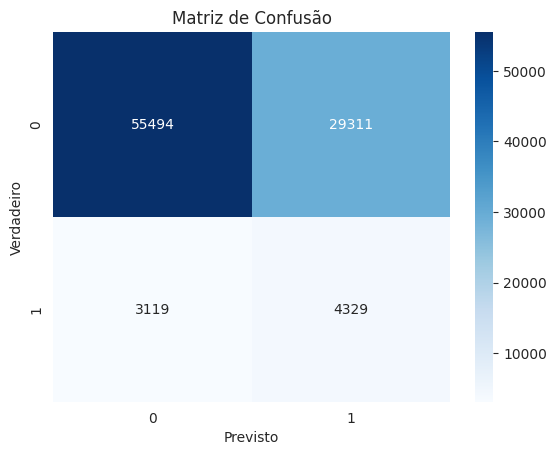

In [17]:
# Célula 7: Avaliação do modelo no conjunto de teste

# Fazendo as previsões
y_pred = lgbm_model.predict(X_test)
y_prob = lgbm_model.predict_proba(X_test)[:, 1]

# Calculando o AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc:.4f}")

# Imprimindo o relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Plotando a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

### Curva ROC

A Curva ROC (Receiver Operating Characteristic) é uma visualização clássica que mostra o trade-off entre a taxa de verdadeiros positivos e a taxa de falsos positivos em todos os limiares de classificação. Um modelo com boa performance terá uma curva que se aproxima do canto superior esquerdo do gráfico.

Plotando a Curva ROC...


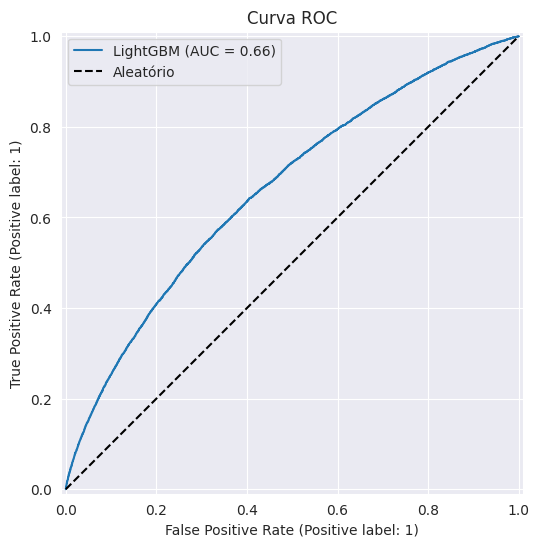

In [18]:
# Célula 8: Plotando a Curva ROC usando Scikit-learn

print("Plotando a Curva ROC...")

fig, ax = plt.subplots(figsize=(8, 6))
roc_display = RocCurveDisplay.from_estimator(lgbm_model, X_test, y_test, ax=ax, name='LightGBM')
ax.plot([0, 1], [0, 1], 'k--', label='Aleatório')
ax.set_title('Curva ROC')
plt.legend()
plt.show()

#Parte 3: Análise de Justiça com Fairlearn


### 7. Análise de Justiça (Fairness) com Fairlearn

Aqui começa a nossa auditoria ética do modelo. Ter um modelo acurado não é suficiente se ele discrimina sistematicamente um grupo de pessoas. Usaremos a biblioteca `fairlearn` para quantificar o viés.

### `MetricFrame`: A Ferramenta Central

A `MetricFrame` nos permite recalcular qualquer métrica da `scikit-learn` de forma agrupada pela nossa feature sensível. Isso nos dá uma visão clara e direta de como o modelo performa para cada grupo.

Métricas de Performance Agrupadas por Gênero:


,accuracy,precision,recall,selection_rate
CODE_GENDER,,,,
Feminino,0.685139,0.114928,0.520413,0.317726
Masculino,0.577780,0.147200,0.662586,0.455096


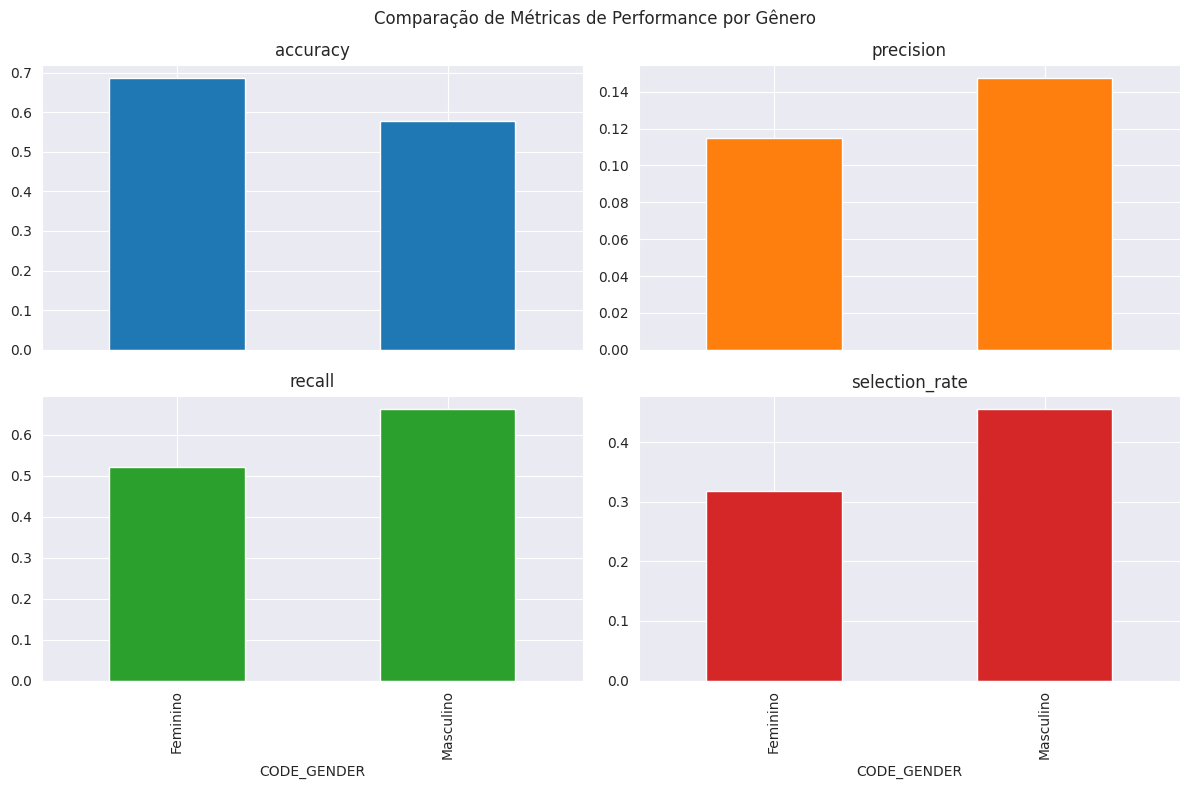

In [19]:
# Célula 9: Usando MetricFrame para agrupar métricas por gênero

from fairlearn.metrics import MetricFrame

# Definindo as métricas que queremos analisar
# selection_rate é a proporção de pessoas que recebem o resultado "positivo" (neste caso, inadimplente = 1)
# É o inverso da taxa de aprovação (1 - taxa de aprovação)
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}

# Criando o MetricFrame
# y_test: os valores verdadeiros
# y_pred: as previsões do nosso modelo
# sensitive_features: o grupo pelo qual queremos analisar (gênero)
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=sensitive_features_test)

# Acessando os resultados agrupados e visualizando
print("Métricas de Performance Agrupadas por Gênero:")
# Usamos .rename() para deixar a saída mais clara (0: Feminino, 1: Masculino)
grouped_metrics = metric_frame.by_group
grouped_metrics.index = grouped_metrics.index.map({0: 'Feminino', 1: 'Masculino'})
display(grouped_metrics)

# Visualizando as diferenças de forma gráfica
grouped_metrics.plot.bar(
    subplots=True,
    layout=(2, 2),
    legend=False,
    figsize=(12, 8),
    title='Comparação de Métricas de Performance por Gênero'
)
plt.tight_layout()
plt.show()

### Critério de Justiça 1: Paridade Demográfica

A Paridade Demográfica (ou *Demographic Parity*) dita que as decisões do modelo devem ser independentes do atributo sensível. No nosso caso, a porcentagem de homens classificados como "inadimplentes" deve ser similar à porcentagem de mulheres classificadas como "inadimplentes".

Calculamos a `demographic_parity_difference`, que é a diferença entre a maior e a menor taxa de seleção entre os grupos. Um valor próximo de zero indica um modelo mais justo sob este critério.

In [20]:
# Célula 10: Calculando a Paridade Demográfica

# A taxa de seleção é a mesma que calculamos com o MetricFrame
selection_rates = metric_frame.by_group['selection_rate']
print("Taxa de Seleção (proporção de negados) por Gênero:")
print(selection_rates)

# Calculando a diferença de paridade demográfica
dp_diff = demographic_parity_difference(y_true=y_test,
                                        y_pred=y_pred,
                                        sensitive_features=sensitive_features_test)

print(f"\nDiferença de Paridade Demográfica: {dp_diff:.4f}")
print("\nAnálise: Um valor de {dp_diff:.4f} significa que a taxa de negação de crédito para um grupo é {dp_diff*100:.2f} pontos percentuais maior que para o outro grupo. Quanto mais perto de zero, mais justo é o modelo neste critério.")

Taxa de Seleção (proporção de negados) por Gênero:
CODE_GENDER
Feminino     0.317726
Masculino    0.455096
Name: selection_rate, dtype: float64

Diferença de Paridade Demográfica: 0.1374

Análise: Um valor de {dp_diff:.4f} significa que a taxa de negação de crédito para um grupo é {dp_diff*100:.2f} pontos percentuais maior que para o outro grupo. Quanto mais perto de zero, mais justo é o modelo neste critério.


### Critério de Justiça 2: Chances Equalizadas

As Chances Equalizadas (*Equalized Odds*) é uma definição de justiça mais rigorosa. Ela exige que o modelo tenha a mesma performance em termos de erros para todos os grupos. Especificamente:
- A **Taxa de Verdadeiros Positivos (Recall)** deve ser igual entre os grupos. (A chance de um inadimplente real ser pego deve ser a mesma para homens e mulheres).
- A **Taxa de Falsos Positivos** deve ser igual entre os grupos. (A chance de um bom pagador ser incorretamente negado deve ser a mesma para homens e mulheres).

Calculamos a `equalized_odds_difference`, que mede a maior diferença nessas taxas de erro. Novamente, quanto mais perto de zero, melhor.

In [21]:
# Célula 11: Calculando as Chances Equalizadas

# O MetricFrame já nos deu o Recall por grupo
recall_by_group = metric_frame.by_group['recall']
print("Recall (Taxa de Verdadeiros Positivos) por Gênero:")
print(recall_by_group)

# Calculando a diferença de chances equalizadas
eo_diff = equalized_odds_difference(y_true=y_test,
                                    y_pred=y_pred,
                                    sensitive_features=sensitive_features_test)

print(f"\nDiferença de Chances Equalizadas: {eo_diff:.4f}")
print("\nAnálise: Este valor representa a maior diferença nas taxas de erro (tanto verdadeiros positivos quanto falsos positivos) entre os grupos. Um valor próximo de zero indica que o modelo comete erros de forma equilibrada entre os grupos.")

Recall (Taxa de Verdadeiros Positivos) por Gênero:
CODE_GENDER
Feminino     0.520413
Masculino    0.662586
Name: recall, dtype: float64

Diferença de Chances Equalizadas: 0.1422

Análise: Este valor representa a maior diferença nas taxas de erro (tanto verdadeiros positivos quanto falsos positivos) entre os grupos. Um valor próximo de zero indica que o modelo comete erros de forma equilibrada entre os grupos.


## 8. Conclusão, Análise Ética e Próximos Passos

Este projeto teve como objetivo não apenas construir um modelo de score de crédito, mas também realizar uma auditoria crítica de sua justiça, um passo fundamental para o desenvolvimento de IA responsável no setor financeiro.

### Avaliação de Performance Preditiva:

O modelo LightGBM, treinado em um subconjunto de features, demonstrou uma capacidade preditiva modesta, alcançando um **AUC-ROC de 0.66**. Ele foi capaz de identificar **58% dos clientes inadimplentes (Recall)**, porém com uma baixa precisão (13%), indicando um alto número de falsos positivos. Embora funcional como um protótipo inicial, esses resultados sugerem a necessidade de uma engenharia de features mais robusta e ajuste de hiperparâmetros para melhorar a performance.

### Análise Crítica de Justiça (Fairness):

A avaliação de viés com a biblioteca `Fairlearn` revelou disparidades significativas na forma como o modelo trata diferentes gêneros, levantando importantes questões éticas:

*   **Viés na Aprovação (Paridade Demográfica):** Encontramos uma **Diferença de Paridade Demográfica de 0.137**. Na prática, isso significa que a taxa de negação de crédito prevista pelo modelo para o grupo **Masculino foi 13.7 pontos percentuais mais alta** que para o grupo Feminino. Essa disparidade não é aceitável em um sistema de crédito justo.

*   **Viés na Taxa de Erros (Chances Equalizadas):** O modelo apresentou uma **Diferença de Chances Equalizadas de 0.142**. Isso se reflete principalmente na diferença de Recall entre os grupos (66% para Masculino vs. 52% para Feminino), indicando que a capacidade do modelo de identificar corretamente um cliente inadimplente não é a mesma para ambos os gêneros.

### Conclusão Estratégica e Próximos Passos:

O resultado deste projeto é claro: **um modelo de score de crédito preditivamente funcional, mas eticamente falho.** A simples implementação deste modelo em produção seria irresponsável e poderia levar a práticas discriminatórias.

Este estudo ressalta a importância crítica de incorporar a análise de justiça como uma etapa não-negociável no ciclo de vida de desenvolvimento de modelos de Machine Learning. Os próximos passos para evoluir este protótipo seriam:

1.  **Melhorar a Performance:** Realizar uma engenharia de features mais aprofundada, utilizando as outras tabelas do dataset, e otimizar os hiperparâmetros do modelo.
2.  **Mitigação de Viés:** Aplicar técnicas de mitigação de viés, como os algoritmos de pós-processamento ou reponderação disponíveis na própria biblioteca `Fairlearn`, para ajustar as decisões do modelo e reduzir as disparidades de justiça encontradas.
3.  **Análise de Trade-off:** Avaliar o impacto das técnicas de mitigação na performance preditiva do modelo. Frequentemente, há um trade-off entre acurácia e justiça, e a decisão de qual modelo usar deve ser uma escolha de negócio informada e ética.

Este projeto demonstra a capacidade de ir além da modelagem tradicional, aplicando uma camada de análise crítica e responsável que é essencial para a criação de sistemas de IA confiáveis e justos.